In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [8]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))


from types import SimpleNamespace

import torch

from torch.utils.data import DataLoader

from ml.models.mlp import MLP
from ml.utils.data_utils import TorchDataset

from ml.utils.metrics import get_classification_metrics, get_probability_measures, get_lift_demotion_scores

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [9]:
%matplotlib inline

In [10]:
thefts = pd.read_csv("../dataset/final/valid_train_thefts.csv")
non_thefts = pd.read_csv("../dataset/final/valid_train_non_theft_suc_theft_acct.csv")
non_thefts2 = pd.read_csv("../dataset/final/non_thefts_k_100000.csv")

df = pd.concat([thefts, non_thefts])
#df.drop(columns=['acct', 'successor', 'voltage'], inplace=True)
df.fillna(-1, inplace=True)

In [14]:
df

,number_of_measurements,number_of_zeros,max_energy_per_day,min_energy_per_day,mean_energy_per_day,median_energy_per_day,std_energy_per_day,max_measurement_interval_in_days,min_measurement_interval_in_days,mean_measurement_interval_in_days,median_measurement_interval_in_days,days_since_last_measurement,parno,xrhsh,contract_capacity,acct_control,number_of_requests,target
0,12,2,18.950000,0.000000,6.735356,7.049180,4.964937,350,15,144.181818,122.0,152,0,1,12.0,0,0,1
1,13,2,12.071429,0.000000,7.221644,10.070525,4.807979,243,6,122.416667,121.0,341,0,1,12.0,0,1,1
2,5,5,0.000000,0.000000,0.000000,0.000000,0.000000,125,120,122.250000,122.0,1251,2,1,25.0,0,3,1
3,6,1,9.434066,4.546448,5.873035,4.989218,1.803735,371,68,197.200000,182.0,190,2,6,25.0,0,0,1
4,8,0,19.565574,1.910569,10.585130,10.008197,5.580233,246,121,139.142857,121.0,821,3,1,35.0,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089,24,0,576.600000,41.480519,253.634949,209.692308,167.690370,77,6,34.434783,30.0,94,3,2,35.0,0,0,0
2090,5,4,0.043011,0.000000,0.010753,0.000000,0.018624,124,93,114.250000,120.0,1346,0,1,12.0,0,3,0
2091,1,0,0.000100,0.000100,0.000100,0.000100,0.000000,0,0,0.000000,0.0,169,0,1,12.0,0,1,0
2092,6,0,14.312500,8.252033,10.474311,9.650000,2.087191,123,32,103.400000,121.0,1292,0,1,12.0,0,8,0


In [11]:
print(len(df))
df.drop(columns=['acct', 'successor', 'voltage'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

3649
3639


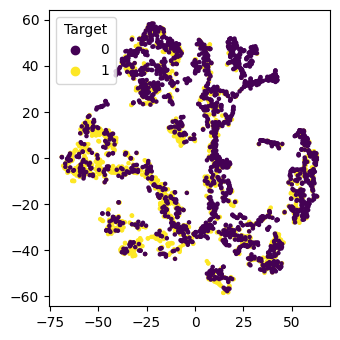

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame

X = df.drop('target', axis=1)
y = df['target']

# Using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

fig, ax = plt.subplots(figsize=(3.5, 3.5))
s = np.where(y == 1, 5, 5)  # Size of the marker, seems like you want it to be 5 for both classes
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=s, cmap='viridis')

# Adding legend
ax.legend(*scatter.legend_elements(), title='Target')
plt.tight_layout()
plt.savefig("tsne.pdf")

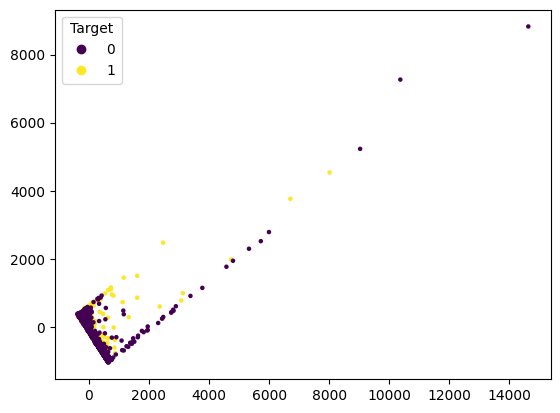

In [12]:
X = df.drop('target', axis=1)
y = df['target']
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

fig, ax = plt.subplots()
s = np.where(y == 1, 5, 5)
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=s, cmap='viridis')
ax.legend(*scatter.legend_elements(), title='Target')
plt.show()

In [7]:
#df.drop(['xrhsh', 'parno', 'acct_control', 'contract_capacity', 'min_measurement_interval_in_days', 'max_energy_per_day'], axis=1, inplace=True)
print("Bincount of y:", df['target'].value_counts())
"""plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')"""

Bincount of y: 0    2084
1    1555
Name: target, dtype: int64


'plt.figure(figsize=(14,8))\nsns.set_theme(style="white")\ncorr = df.corr()\nheatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt=\'.1g\')'

In [8]:
df.head()

,number_of_measurements,number_of_zeros,max_energy_per_day,min_energy_per_day,mean_energy_per_day,median_energy_per_day,std_energy_per_day,max_measurement_interval_in_days,min_measurement_interval_in_days,mean_measurement_interval_in_days,median_measurement_interval_in_days,days_since_last_measurement,parno,xrhsh,contract_capacity,acct_control,number_of_requests,target
0,12,2,18.950000,0.000000,6.735356,7.049180,4.964937,350,15,144.181818,122.0,152,0,1,12.0,0,0,1
1,13,2,12.071429,0.000000,7.221644,10.070525,4.807979,243,6,122.416667,121.0,341,0,1,12.0,0,1,1
2,5,5,0.000000,0.000000,0.000000,0.000000,0.000000,125,120,122.250000,122.0,1251,2,1,25.0,0,3,1
3,6,1,9.434066,4.546448,5.873035,4.989218,1.803735,371,68,197.200000,182.0,190,2,6,25.0,0,0,1
4,8,0,19.565574,1.910569,10.585130,10.008197,5.580233,246,121,139.142857,121.0,821,3,1,35.0,0,5,1


In [9]:
# define X and y
X = df.drop('target', axis=1)
y = df['target']

In [10]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))


from types import SimpleNamespace

import torch

from torch.utils.data import DataLoader

from models.mlp import MLP
from utils.data_utils import TorchDataset

from utils.metrics import get_classification_metrics, get_probability_measures, get_lift_demotion_scores

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [11]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
scaler = MinMaxScaler()

In [13]:
rf_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42, probability=True)
knn_clf = KNeighborsClassifier()
lr_clf = LogisticRegression(random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
cat_clf = CatBoostClassifier(random_state=42)
xgb_clf = XGBClassifier(random_state=42)
clfs = {'RandomForest': rf_clf, 'SVM': svm_clf, 'kNN': knn_clf,
        'LogisticRegression': lr_clf,'DecisionTree': dt_clf,
        'XGB': xgb_clf,
       'CatBoost': cat_clf, 'MLP': None}

In [14]:
for clf_name, clf in clfs.items():
    # Initialize the evaluation metrics lists
    acc_scores = []
    prec_scores = []
    rec_scores = []
    f1_scores = []
    brier_scores, auc_roc_scores, pr_auc_scores = [], [], []
    lift_scores, demotion_scores, weighted_scores = [], [], []
    

    print("Classifier:", clf_name)

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_test = pd.concat([X_test, non_thefts2.drop(['acct', 'successor', 'voltage', 'target'], axis=1)])
        y_test = pd.concat([y_test, non_thefts2['target']])
        
        print("Bincount of y_train:", np.bincount(y_train.values))
        print("Bincount of y_test:", np.bincount(y_test.values))
        
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        

        if clf_name == "CatBoost":
            clf.fit(X_train, y_train, verbose=False)
            
        elif clf_name == "MLP":
            train_dataset = TorchDataset(X=torch.tensor(X_train).float(), y=torch.tensor(y_train.to_numpy()).float())  # reconstruction
            test_dataset = TorchDataset(X=torch.tensor(X_test).float(), y=torch.tensor(y_test.to_numpy()).float())

            train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
            clf = MLP(in_size=X_train.shape[1], layer_units=[16, 32, 64], out_size=1, vae=False)
            optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)
            criterion = torch.nn.BCEWithLogitsLoss()
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            args = dict(model=clf, train_loader=train_loader, test_loader=test_loader,
            epochs=100, optimizer=optimizer, criterion=criterion,
            reconstruction=False, vae=False, device=device, verbose=False, return_best=True)
            args = SimpleNamespace(**args)
            clf = clf.fit(args)
            
        else:
            clf.fit(X_train, y_train)

        if clf_name != "MLP":
            y_pred = clf.predict(X_test)

            acc, precision, recall, f1 = get_classification_metrics(y_test.values, y_pred)
            
            y_scores = clf.predict_proba(X_test)
            idx = np.argmax(y_scores, axis=1)
            y_scores = np.where(idx == 0, 1 - y_scores[:, 0], y_scores[:, 1])


            brier, roc_auc, pr_auc = get_probability_measures(y_test.values, y_scores)

            num_ones = np.sum(y_test == 1)
            lift, demotion, weighted_score = get_lift_demotion_scores(y_test.values, y_scores,
                                                                      num_samples=int(0.1 * num_ones))
        else:
            args = dict(
                model=clf,
                data_loader=test_loader, criterion=criterion,
            reconstruction=False, vae=False, device=device)
            args = SimpleNamespace(**args)
            _, acc, precision, recall, f1, brier, roc_auc, pr_auc, lift, demotion, weighted_score = clf.predict(
                args
            )
        
        acc_scores.append(acc)
        prec_scores.append(precision)
        rec_scores.append(recall)
        f1_scores.append(f1)
        
        brier_scores.append(brier)
        auc_roc_scores.append(roc_auc)
        pr_auc_scores.append(pr_auc)
        
        lift_scores.append(lift)
        demotion_scores.append(demotion)
        weighted_scores.append(weighted_score)
        
        print("Fold {} - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Brier: {:.4f}, AUC-ROC: {:.4f}, PR-AUC: {:.4f}, Lift: {:.4f}, Demotion: {:.4f}, Weighted: {:.4f}"
              .format(len(acc_scores), acc_scores[-1], prec_scores[-1], rec_scores[-1], f1_scores[-1],
                     brier_scores[-1], auc_roc_scores[-1], pr_auc_scores[-1],
                     lift_scores[-1], demotion_scores[-1], weighted_scores[-1]))

    print("Average - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Brier: {:.4f}, AUC-ROC: {:.4f}, PR-AUC: {:.4f}, Lift: {:.4f}, Demotion: {:.4f}, Weighted: {:.4f}\n"
          .format(sum(acc_scores)/len(acc_scores), sum(prec_scores)/len(prec_scores),
                  sum(rec_scores)/len(rec_scores), sum(f1_scores)/len(f1_scores),
                 sum(brier_scores)/len(brier_scores), sum(auc_roc_scores)/len(auc_roc_scores), sum(pr_auc_scores)/len(pr_auc_scores),
                 sum(lift_scores)/len(lift_scores), sum(demotion_scores)/len(demotion_scores), sum(weighted_scores)/len(weighted_scores)))


Classifier: RandomForest
Bincount of y_train: [1667 1244]
Bincount of y_test: [100130    311]
Fold 1 - Accuracy: 0.4813, Precision: 0.0041, Recall: 0.6945, F1: 0.0082, Brier: 0.3634, AUC-ROC: 0.5953, PR-AUC: 0.0052, Lift: 0.0645, Demotion: 1.0000, Weighted: 0.3452
Bincount of y_train: [1667 1244]
Bincount of y_test: [100130    311]
Fold 2 - Accuracy: 0.4857, Precision: 0.0042, Recall: 0.7010, F1: 0.0084, Brier: 0.3413, AUC-ROC: 0.6239, PR-AUC: 0.0056, Lift: 0.0000, Demotion: 1.0000, Weighted: 0.3000
Bincount of y_train: [1667 1244]
Bincount of y_test: [100130    311]
Fold 3 - Accuracy: 0.4840, Precision: 0.0039, Recall: 0.6527, F1: 0.0078, Brier: 0.3485, AUC-ROC: 0.5933, PR-AUC: 0.0058, Lift: 0.0323, Demotion: 1.0000, Weighted: 0.3226
Bincount of y_train: [1667 1244]
Bincount of y_test: [100130    311]
Fold 4 - Accuracy: 0.4766, Precision: 0.0039, Recall: 0.6559, F1: 0.0077, Brier: 0.3638, AUC-ROC: 0.5859, PR-AUC: 0.0043, Lift: 0.0323, Demotion: 1.0000, Weighted: 0.3226
Bincount of y_t

Fold 1 - Accuracy: 0.4888, Precision: 0.0042, Recall: 0.6881, F1: 0.0083, Brier: 0.3762, AUC-ROC: 0.6287, PR-AUC: 0.0081, Lift: 0.0000, Demotion: 1.0000, Weighted: 0.3000
Bincount of y_train: [1667 1244]
Bincount of y_test: [100130    311]
Fold 2 - Accuracy: 0.4912, Precision: 0.0045, Recall: 0.7363, F1: 0.0089, Brier: 0.3568, AUC-ROC: 0.6524, PR-AUC: 0.0082, Lift: 0.0323, Demotion: 1.0000, Weighted: 0.3226
Bincount of y_train: [1667 1244]
Bincount of y_test: [100130    311]
Fold 3 - Accuracy: 0.4883, Precision: 0.0039, Recall: 0.6527, F1: 0.0078, Brier: 0.3769, AUC-ROC: 0.6068, PR-AUC: 0.0087, Lift: 0.0645, Demotion: 1.0000, Weighted: 0.3452
Bincount of y_train: [1667 1244]
Bincount of y_test: [100130    311]
Fold 4 - Accuracy: 0.4859, Precision: 0.0040, Recall: 0.6624, F1: 0.0079, Brier: 0.3799, AUC-ROC: 0.6076, PR-AUC: 0.0077, Lift: 0.0968, Demotion: 1.0000, Weighted: 0.3677
Bincount of y_train: [1668 1244]
Bincount of y_test: [100129    311]
Fold 5 - Accuracy: 0.4853, Precision: 0.